# Peer-graded Assignment: Week 5: GANs

## Introduction: Stylizing Images with GANs Inspired by Monet

In this project, we explore how artificial intelligence—specifically *Generative Adversarial Networks (GANs)*—can be applied to replicate the distinct artistic style of Claude Monet. 

By training a GAN model on Monet’s artwork, our goal is to generate new images that reflect the impressionistic textures, colors, and brushwork found in his masterpieces. This effort combines the power of:

- **AI and Deep Learning**: Leveraging neural networks to understand and mimic artistic patterns.
- **Computer Vision**: Interpreting and generating image content.
- **Art and Creativity**: Translating classical painting techniques into generative digital art.


## Problem Definition: Monet-Style Image Generation Using GANs

The goal of this project is to design and train a **Generative Adversarial Network (GAN)** that can produce a large collection—between 7,000 and 10,000—of images that convincingly reflect the artistic style of Claude Monet.

A GAN consists of two core neural networks:

- **🧠 Generator**: Learns to create images that imitate Monet’s impressionistic style.
- **🔍 Discriminator**: Acts as a critic, trying to distinguish between real Monet paintings and synthetic images generated by the model.

These two models are trained in a competitive framework:
- The **generator** tries to fool the discriminator by generating realistic Monet-style images.
- The **discriminator** tries to correctly classify images as either real (authentic Monet) or fake (generated by the model).


## Importing Libraries and Setting Up the Environment

In this section, we import all the essential libraries required for building and training our GAN model.

- **PyTorch**: The core deep learning framework used to build and train neural networks.
- **Torchvision & PIL**: Tools for image loading and preprocessing.
- **Matplotlib**: For visualizing images generated during training.
- **TQDM**: Adds a progress bar to training loops, enhancing interpretability and debugging.
- **OS and Shutil**: For file and directory manipulation.
- **NumPy**: For efficient numerical computations.


In [1]:
import os                          # For file path and directory handling
import shutil                     # For high-level file operations
import numpy as np                # For numerical operations

import torch                      # PyTorch main package
import torch.nn as nn             # Neural network components
from torch.nn.utils import clip_grad_norm_  # To clip gradients and avoid exploding gradients

from torch.utils.data import Dataset, DataLoader  # For handling custom datasets and batching
import torchvision.transforms as transforms       # Image transformation utilities

from tqdm.notebook import tqdm     # Progress bar for notebook environments
import matplotlib.pyplot as plt    # For plotting generated images
from PIL import Image              # For image loading and processing

## Setting Seed and Device Configuration

To ensure reproducibility of our results, we set a fixed random seed for both NumPy and PyTorch. This makes the model's training behavior consistent across runs.

We also configure the computational device:
- If a GPU is available, the code will utilize it for faster training.
- Otherwise, it defaults to the CPU.

Additionally, setting `torch.backends.cudnn.deterministic = True` ensures deterministic behavior when using CUDA operations—important for consistent debugging and evaluation.


In [2]:
#Setting Random Seed and Configuring Device

seed = 142  # Chosen seed for reproducibility

# Set seeds for NumPy and PyTorch (CPU and GPU)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Ensures deterministic results with CUDA (slightly slower but reproducible)
torch.backends.cudnn.deterministic = True

# Configure device to use GPU if available, else fallback to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Loading and Preparing the Monet and Photo Datasets

In this section, we create a custom PyTorch `Dataset` to load Monet-style paintings and real-world photographs.

### Key Points:
- **Monet Dataset** contains 300 curated Monet-style images.
- **Photo Dataset** is larger (>7,000 images), but we only randomly sample from the first 300 during training for balance.
- Images are preprocessed using common augmentation techniques:
  - Random horizontal and vertical flips to enhance variety.
  - Normalization to scale pixel values into a range suitable for GAN training.

### DataLoader Setup:
- A PyTorch `DataLoader` is created to handle batching and shuffling during training.

### Visualization:
- A helper function `unnorm()` is provided to reverse normalization for visual display of generated or real images.


In [3]:
# Loading Monet and Photo Datasets with Custom PyTorch Dataset
class ImageDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        """
        Initializes dataset with Monet and photo images.
        Applies optional image transformations.
        """
        monet_dir = os.path.join(data_dir, 'monet_jpg')
        photo_dir = os.path.join(data_dir, 'photo_jpg')
        
        self.files_monet = [os.path.join(monet_dir, name) for name in sorted(os.listdir(monet_dir))]
        self.files_photo = [os.path.join(photo_dir, name) for name in sorted(os.listdir(photo_dir))]

        self.transforms = transforms
        
    def __len__(self):
        # Use the size of the Monet dataset (300 images)
        return len(self.files_monet)
    
    def __getitem__(self, index):
        # Randomly sample a photo image for training
        random_index = np.random.randint(0, len(self.files_monet))  # limited to 300 photos for balanced training

        file_monet = self.files_monet[index]
        file_photo = self.files_photo[random_index]

        image_monet = Image.open(file_monet)
        image_photo = Image.open(file_photo)

        if self.transforms:
            image_monet = self.transforms(image_monet)
            image_photo = self.transforms(image_photo)

        return image_monet, image_photo


# Dataset Directory and DataLoader Setup
data_dir = '/kaggle/input/gan-getting-started'
batch_size = 5

# Image Preprocessing Pipeline
transforms_ = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# DataLoader Initialization
dataloader = DataLoader(
    ImageDataset(data_dir, transforms=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

# Utility: Function to Unnormalize Images for Display
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Reverses the normalization for visualization.
    """
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # correct: add m, not s
    return img

## Convolutional and Residual Blocks

In this section, we define two foundational components of our GAN architecture:

### `ConvBlock`
A flexible convolutional block that can be used in both the **generator** and **discriminator**. It supports:
- **Standard or transposed convolution**
- **Optional instance normalization** (ideal for style transfer tasks)
- **Optional dropout** for regularization
- **Configurable activation**: LeakyReLU (default) or ReLU

This modular design enables reuse across different parts of the GAN.

### `ResidualBlock`
A building block used in the **generator** network. It allows the model to:
- Preserve low-level features through **skip connections**
- Learn transformations without losing essential spatial information
- Reduce visual artifacts using **reflection padding**


In [4]:
# Convolutional Block and Residual Block for GAN Architecture

import torch.nn as nn

class ConvBlock(nn.Module):
    """
    A modular convolutional block that supports:
    - Conv2D or ConvTranspose2D
    - Optional instance normalization
    - Optional dropout
    - LeakyReLU or ReLU activation
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0,
                 transpose=False, use_leaky=True, use_dropout=False, normalize=True):
        super(ConvBlock, self).__init__()
        layers = []

        if transpose:
            # Used in the decoder or upsampling blocks
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                             stride, padding, output_padding=1))
        else:
            # Standard convolution layer
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size,
                                    stride, padding, bias=True))

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))  # better for style transfer

        if use_dropout:
            layers.append(nn.Dropout(0.5))

        # Activation function
        if use_leaky:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        else:
            layers.append(nn.ReLU(inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class ResidualBlock(nn.Module):
    """
    A residual block used in the generator.
    Helps retain content while allowing style adaptation.
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),  # Reduces edge artifacts
            ConvBlock(in_channels=channels, out_channels=channels,
                      kernel_size=3, use_leaky=False, use_dropout=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        # Add skip connection to preserve input features
        return x + self.block(x)


## Generator Network Architecture

This generator follows an **Encoder → Transformer → Decoder** structure designed to perform style transfer from photo to Monet-style artwork.

### Encoder
- Begins with a reflection padding to preserve borders.
- Two convolutional layers downsample the input image (3×256×256) to a feature representation of size (256×64×64).

### Transformer (ResNet Bottleneck)
- Consists of 9 residual blocks that retain content while learning the Monet style.
- Keeps feature shape constant (256×64×64).

### Decoder
- Two transposed convolutional layers upsample the feature map back to (64×256×256).
- The final layer reduces it to a 3-channel image with `Tanh` activation (output range [-1, 1]).

### Purpose
This architecture is tailored to translate real photographs into Monet-style paintings, preserving structure while adapting texture, color, and brushwork.


In [5]:
# Generator Network: Encoder → Transformer → Decoder

class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_blocks=9):
        """
        Generator architecture for style transfer using:
        - Encoder: Downsampling
        - Transformer: Residual blocks for style representation
        - Decoder: Upsampling to reconstruct output
        """
        super(Generator, self).__init__()

        # Encoder
        # Input: (3, 256, 256) → Output: (64, 256, 256)
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),  # Padding to preserve edges
            ConvBlock(in_channels=in_channels, out_channels=64,
                      kernel_size=2 * in_channels + 1, use_leaky=False),
        )

        # Downsampling layers: (64 → 128 → 256)
        self.down = nn.Sequential(
            ConvBlock(64, 128, kernel_size=3, stride=2, padding=1, use_leaky=False),   # (128, 128, 128)
            ConvBlock(128, 256, kernel_size=3, stride=2, padding=1, use_leaky=False),  # (256, 64, 64)
        )

        # Transformer (ResNet Bottleneck)
        self.transform = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])  # (256, 64, 64)

        # Decoder (Upsampling)
        self.up = nn.Sequential(
            ConvBlock(256, 128, kernel_size=3, stride=2, padding=1, transpose=True, use_leaky=False),  # (128, 128, 128)
            ConvBlock(128, 64, kernel_size=3, stride=2, padding=1, transpose=True, use_leaky=False),   # (64, 256, 256)
        )

        # Output Layer: (64 → 3 channels), using Tanh to scale to [-1, 1]
        self.out = nn.Sequential(
            nn.ReflectionPad2d(out_channels),
            nn.Conv2d(64, out_channels, kernel_size=2 * out_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.down(self.initial(x))
        x = self.transform(x)
        x = self.out(self.up(x))
        return x


## Discriminator Network

The **Discriminator** plays the role of an art critic in our GAN architecture. It judges whether an image is a real Monet painting or a generated one.

### Architecture Overview

We use a **PatchGAN** discriminator, which outputs a grid of probabilities rather than a single value. Each patch (e.g., 70×70 region) of the image is evaluated independently, allowing the discriminator to focus on **local features** like textures and brushstrokes.

### Layer Breakdown:
- Input: **(3, 256, 256)** image
- 4 convolutional layers progressively **downsample** the image to smaller feature maps.
- Final output: **(1, 30, 30)** score map, where each value represents the realism of a specific patch.

### Purpose:
This structure allows the GAN to learn fine-grained details and helps the generator produce more convincing, texture-rich results—key to Monet-style image synthesis.


In [6]:
# Discriminator Network: PatchGAN-Based Image Classifier

class Discriminator(nn.Module):
    def __init__(self, in_channels):
        """
        PatchGAN discriminator for distinguishing real vs. generated images.
        Takes an input image and returns a (1, 30, 30) feature map
        representing the realism of local patches.
        """
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: (3, 256, 256) → Output: (64, 128, 128)
            ConvBlock(in_channels, 64, kernel_size=4, stride=2, padding=1, normalize=False),

            # Downsampling layers
            ConvBlock(64, 128, kernel_size=4, stride=2, padding=1),    # (128, 64, 64)
            ConvBlock(128, 256, kernel_size=4, stride=2, padding=1),   # (256, 32, 32)
            ConvBlock(256, 512, kernel_size=4, stride=1, padding=1),   # (512, 31, 31)

            # Final output layer: binary classification at patch level
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)       # (1, 30, 30)
        )

    def forward(self, x):
        return self.model(x)


## Initializing CycleGAN Models and Loss Functions

This section defines the **core components of the CycleGAN architecture**, which involves **two generators** and **two discriminators**:

### Generators:
- `Monet → Photo`: Learns to convert Monet-style images into realistic photos.
- `Photo → Monet`: Learns to stylize photos to resemble Monet paintings.

### Discriminators:
- `Discriminator Monet`: Judges whether a Monet image is real or generated.
- `Discriminator Photo`: Judges whether a photo is real or generated.

### Loss Functions:
- `criterion_GAN`: Mean Squared Error (MSE) is used to measure adversarial loss (how "real" the discriminator thinks the generated image is).
- `criterion_cycle`: L1 loss that encourages **cycle consistency**—i.e., an image translated to another domain and back should match the original.
- `criterion_identity`: Also L1 loss, used to enforce **identity mapping**, ensuring that passing real images from the target domain through the generator doesn’t change them unnecessarily.

These models and losses are the building blocks for training a CycleGAN to perform high-fidelity style transfer between Monet paintings and real photographs.


In [7]:
# Initializing Generators and Discriminators for CycleGAN
# Generator: Monet → Photo
generator_monet2photo = Generator(in_channels=3, out_channels=3, num_residual_blocks=9).to(device)
# Generator: Photo → Monet
generator_photo2monet = Generator(in_channels=3, out_channels=3, num_residual_blocks=9).to(device)
# Discriminator for Monet images (real vs fake Monet)
discriminator_monet = Discriminator(in_channels=3).to(device)
# Discriminator for Photo images (real vs fake Photo)
discriminator_photo = Discriminator(in_channels=3).to(device)

# Loss Functions Setup
# GAN Loss: Forces generator to produce realistic images (Patch-level realism)
criterion_GAN = nn.MSELoss()
# Cycle Consistency Loss: Ensures that translation back to the original domain is accurate
criterion_cycle = nn.L1Loss()
# Identity Loss: Encourages color and content preservation when input is already in the target domain
criterion_identity = nn.L1Loss()

## Optimizer Initialization for CycleGAN

This section sets up the optimizers used to train the CycleGAN architecture.

### Optimizer Choice: Adam
We use the **Adam optimizer** for both generators and discriminators due to its stability and performance in GAN training.

### Hyperparameters:
- **Learning rate (`lr`)**: Set to `2e-4`, a commonly used default for CycleGANs.
- **Betas (`b1=0.5`, `b2=0.999`)**: Momentum terms that help stabilize adversarial training.

### Optimizers:
- `optim_generators`: Updates the weights for **both generators** (Monet ↔ Photo).
- `optim_discriminators`: Updates the weights for **both discriminators** (real vs fake Monet and Photo).


In [8]:
# Optimizer Initialization for Generators and Discriminators

# Learning rate for all optimizers
lr = 2e-4

# Adam optimizer beta parameters: commonly used for GAN training
b1 = 0.5
b2 = 0.999

# Optimizer for both generators (Monet→Photo and Photo→Monet)
optim_generators = torch.optim.Adam(
    list(generator_monet2photo.parameters()) + list(generator_photo2monet.parameters()),
    lr=lr, betas=(b1, b2)
)

# Optimizer for both discriminators (Monet and Photo)
optim_discriminators = torch.optim.Adam(
    list(discriminator_monet.parameters()) + list(discriminator_photo.parameters()),
    lr=lr, betas=(b1, b2)
)

## Learning Rate Scheduling for CycleGAN Training

To ensure effective convergence, we apply a **custom learning rate decay** during training.

### Configuration:
- **Total epochs**: `10`
- **Decay starts at**: `epoch 3`
- **Decay formula**:
  \[
  \text{LR}_{epoch} = 1 - \frac{\max(0, \text{epoch} - \text{decay\_epoch})}{\text{num\_epochs} - \text{decay\_epoch}}
  \]

This function linearly decays the learning rate to zero by the final epoch, starting from `decay_epoch`.

### Purpose:
Gradually reducing the learning rate helps:
- Fine-tune the generator/discriminator balance
- Prevent overshooting optimal weights
- Improve training stability and final image quality

Two schedulers are applied:
- `lr_sched_generators` for both generators
- `lr_sched_discriminators` for both discriminators


In [9]:
# Learning Rate Scheduling for Generators and Discriminators

# Total number of training epochs
num_epochs = 10

# Epoch to start decaying the learning rate
decay_epoch = 3

# Lambda function to compute decay factor after decay_epoch
lr_sched_step = lambda epoch: 1 - max(0, epoch - decay_epoch) / (num_epochs - decay_epoch)

# Scheduler for generator optimizers
lr_sched_generators = torch.optim.lr_scheduler.LambdaLR(
    optim_generators, lr_lambda=lr_sched_step
)

# Scheduler for discriminator optimizers
lr_sched_discriminators = torch.optim.lr_scheduler.LambdaLR(
    optim_discriminators, lr_lambda=lr_sched_step
)


## History, Buffer, and Gradient Control Utilities

This section defines useful classes and functions that support training and visualization.

---

### `History` Class
Tracks the training loss of:
- **Generators**
- **Discriminators**

Includes a `show()` method to visualize training progress over time. Helpful for diagnosing training stability and convergence.

---

### `Buffer` Class
Maintains a **replay buffer** of previously generated images to:
- Increase training stability
- Reduce oscillations during discriminator updates

Instead of always training on fresh generator output, the discriminator is occasionally trained on **older fakes**, simulating a more varied fake dataset.

---

### `update_req_grad()` Function
Enables or disables gradient calculation for a list of models.
- Helps freeze discriminator weights when updating generators, and vice versa.
- Essential for alternating GAN training steps without interfering gradients.


In [10]:
# Class for Tracking and Visualizing Training Losses
class History:
    def __init__(self):
        self.generators_loss = []       # Stores total generator loss (GAN + cycle + identity)
        self.discriminators_loss = []   # Stores total discriminator loss

    def update(self, gen_loss, discr_loss):
        """Updates loss history at each epoch."""
        self.generators_loss.append(gen_loss)
        self.discriminators_loss.append(discr_loss)

    def show(self, title='Losses'):
        """Plots the loss history over training epochs."""
        plt.figure(figsize=(20, 8))
        plt.title(title)
        plt.plot(self.generators_loss, 'o-', color='r', linewidth=2, markersize=3, label='Generators Loss')
        plt.plot(self.discriminators_loss, 'o-', color='b', linewidth=2, markersize=3, label='Discriminators Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.show()


# Class for Managing an Image Replay Buffer (used in CycleGAN)
class Buffer:
    def __init__(self, max_images=50):
        self.max_images = max_images
        self.images = []

    def update(self, images):
        """Updates the buffer with new images, randomly replacing old ones."""
        images = images.detach().cpu().data.numpy()
        for image in images:
            if len(self.images) < self.max_images:
                self.images.append(image)
            else:
                if np.random.rand() > 0.5:
                    index = np.random.randint(0, self.max_images)
                    self.images[index] = image

    def sample(self, num_images):
        """Randomly samples images from the buffer."""
        samples = np.array([self.images[np.random.randint(0, len(self.images))]
                            for _ in range(num_images)])
        return torch.tensor(samples)


# Utility to Freeze or Unfreeze Model Parameters
def update_req_grad(models, requires_grad=True):
    """
    Sets requires_grad for all parameters in the given model(s).
    Used to control whether gradients are computed during backprop.
    """
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad


## Training Loop for CycleGAN

This is the core training loop where both the **generators** and **discriminators** are trained iteratively.

### Key Components:

#### Generator Training
- Learns to:
  - Convert Monet → Photo
  - Convert Photo → Monet
- Optimizes for:
  - **Adversarial loss**: Fool the discriminator
  - **Cycle consistency loss**: Round-trip input should remain the same
  - **Identity loss**: Avoid unnecessary changes when input already belongs to the target domain

#### Discriminator Training
- Judges if generated images are real or fake
- Uses a **replay buffer** to introduce historical fake samples
- Applies **label noise** to real labels for training stability

### Stability Techniques:
- **Gradient clipping** to avoid exploding gradients
- **Label smoothing/noising** to prevent the discriminator from overpowering the generator

### Logging and Visualization:
- Generator and discriminator losses tracked via the `History` class
- Every 10 epochs, displays example real photos and their generated Monet-style counterparts


In [11]:
# 🚀 Training CycleGAN Models (Generators + Discriminators)
history = History()
buffer_monet = Buffer()
buffer_photo = Buffer()

for epoch in range(num_epochs):
    avg_generators_loss = 0
    avg_discriminators_loss = 0
    
    for i, (real_monet, real_photo) in enumerate(tqdm(dataloader, leave=False, total=len(dataloader))):
        real_monet, real_photo = real_monet.to(device), real_photo.to(device)
        
        # ===================== Train Generators =====================
        update_req_grad([generator_monet2photo, generator_photo2monet], True)
        update_req_grad([discriminator_monet, discriminator_photo], False)
        optim_generators.zero_grad()

        # Forward pass
        fake_photo = generator_monet2photo(real_monet)
        fake_monet = generator_photo2monet(real_photo)
        cycle_photo = generator_monet2photo(fake_monet)
        cycle_monet = generator_photo2monet(fake_photo)
        identity_photo = generator_monet2photo(real_photo)
        identity_monet = generator_photo2monet(real_monet)

        # Update buffers
        buffer_photo.update(fake_photo)
        buffer_monet.update(fake_monet)

        # Discriminator predictions on generated images
        pred_fake_photo = discriminator_photo(fake_photo)
        pred_fake_monet = discriminator_monet(fake_monet)

        # Ground truth labels
        labels_real = torch.ones_like(pred_fake_monet).to(device)
        labels_fake = torch.zeros_like(pred_fake_monet).to(device)

        # Losses
        loss_GAN_m2p = criterion_GAN(pred_fake_photo, labels_real)
        loss_GAN_p2m = criterion_GAN(pred_fake_monet, labels_real)
        loss_GAN = (loss_GAN_m2p + loss_GAN_p2m) / 2

        loss_cycle = (criterion_cycle(cycle_photo, real_photo) +
                      criterion_cycle(cycle_monet, real_monet)) / 2

        loss_identity = (criterion_identity(identity_photo, real_photo) +
                         criterion_identity(identity_monet, real_monet)) / 2

        # Total generator loss
        loss_generators_total = loss_GAN + 10 * loss_cycle + 5 * loss_identity
        loss_generators_total.backward()
        optim_generators.step()

        # Clip gradients to avoid explosion
        clip_grad_norm_(generator_photo2monet.parameters(), 100)
        clip_grad_norm_(generator_monet2photo.parameters(), 100)

        # ===================== Train Discriminators =====================
        update_req_grad([discriminator_monet, discriminator_photo], True)
        update_req_grad([generator_monet2photo, generator_photo2monet], False)
        optim_discriminators.zero_grad()

        # Sample images from buffer
        fake_photo = buffer_photo.sample(num_images=batch_size).to(device)
        fake_monet = buffer_monet.sample(num_images=batch_size).to(device)

        # Add label noise to real labels
        threshold = min(1, 0.85 + (1 - 0.85) * epoch / (num_epochs // 2))
        noisy_labels_real = (torch.rand_like(labels_real) < threshold).float().to(device)

        # Compute discriminator losses
        loss_real_photo = criterion_GAN(discriminator_photo(real_photo), noisy_labels_real)
        loss_fake_photo = criterion_GAN(discriminator_photo(fake_photo.detach()), labels_fake)
        loss_photo = (loss_real_photo + loss_fake_photo) / 2

        loss_real_monet = criterion_GAN(discriminator_monet(real_monet), noisy_labels_real)
        loss_fake_monet = criterion_GAN(discriminator_monet(fake_monet.detach()), labels_fake)
        loss_monet = (loss_real_monet + loss_fake_monet) / 2

        loss_discriminators_total = loss_photo + loss_monet
        loss_discriminators_total.backward()
        optim_discriminators.step()

        # Clip gradients
        clip_grad_norm_(discriminator_monet.parameters(), 100)
        clip_grad_norm_(discriminator_photo.parameters(), 100)

        # Accumulate losses
        avg_generators_loss += loss_generators_total.item()
        avg_discriminators_loss += loss_discriminators_total.item()

    # Epoch summary
    avg_generators_loss /= len(dataloader)
    avg_discriminators_loss /= len(dataloader)
    history.update(avg_generators_loss, avg_discriminators_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Generator Loss: {avg_generators_loss:.4f} | Discriminator Loss: {avg_discriminators_loss:.4f}")

    # Visualization
    if (epoch + 1) % 10 == 0:
        _, sample_real_photo = next(iter(dataloader))
        sample_fake_monet = generator_photo2monet(sample_real_photo.to(device)).detach().cpu()
        num_photos = min(batch_size, 5)

        plt.figure(figsize=(20, 8))
        for k in range(num_photos):
            plt.subplot(2, num_photos, k + 1)
            plt.imshow(unnorm(sample_real_photo[k]).permute(1, 2, 0))
            plt.title('Input Photo')
            plt.axis('off')

            plt.subplot(2, num_photos, k + num_photos + 1)
            plt.imshow(unnorm(sample_fake_monet[k]).permute(1, 2, 0))
            plt.title('Generated Monet')
            plt.axis('off')
        plt.show()

    # Step learning rate schedulers
    lr_sched_generators.step()
    lr_sched_discriminators.step()


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/10 | Generator Loss: 5.2935 | Discriminator Loss: 0.6803


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2/10 | Generator Loss: 4.5727 | Discriminator Loss: 0.4761


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3/10 | Generator Loss: 4.4981 | Discriminator Loss: 0.5502


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4/10 | Generator Loss: 4.0102 | Discriminator Loss: 0.4105


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5/10 | Generator Loss: 3.8403 | Discriminator Loss: 0.3681


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 6/10 | Generator Loss: 3.7230 | Discriminator Loss: 0.3195


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 7/10 | Generator Loss: 3.4404 | Discriminator Loss: 0.2670


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 8/10 | Generator Loss: 3.4188 | Discriminator Loss: 0.2672


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 9/10 | Generator Loss: 3.2618 | Discriminator Loss: 0.2598


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 10/10 | Generator Loss: 3.2240 | Discriminator Loss: 0.2634


# Assessing Model Convergence and Performance

To evaluate the training progress of the CycleGAN, we plot the loss curves recorded by the `History` class.

### What It Shows:
- **Generator Loss**: Tracks how well the generators are fooling the discriminators while maintaining cycle and identity consistency.
- **Discriminator Loss**: Indicates how well the discriminators are distinguishing between real and generated images.

### Why It Matters:
- **Decreasing losses** with stabilizing gaps between generator and discriminator curves usually indicate proper convergence.
- **Oscillations or divergence** may suggest training instability or the need for more epochs, tuning, or better regularization.


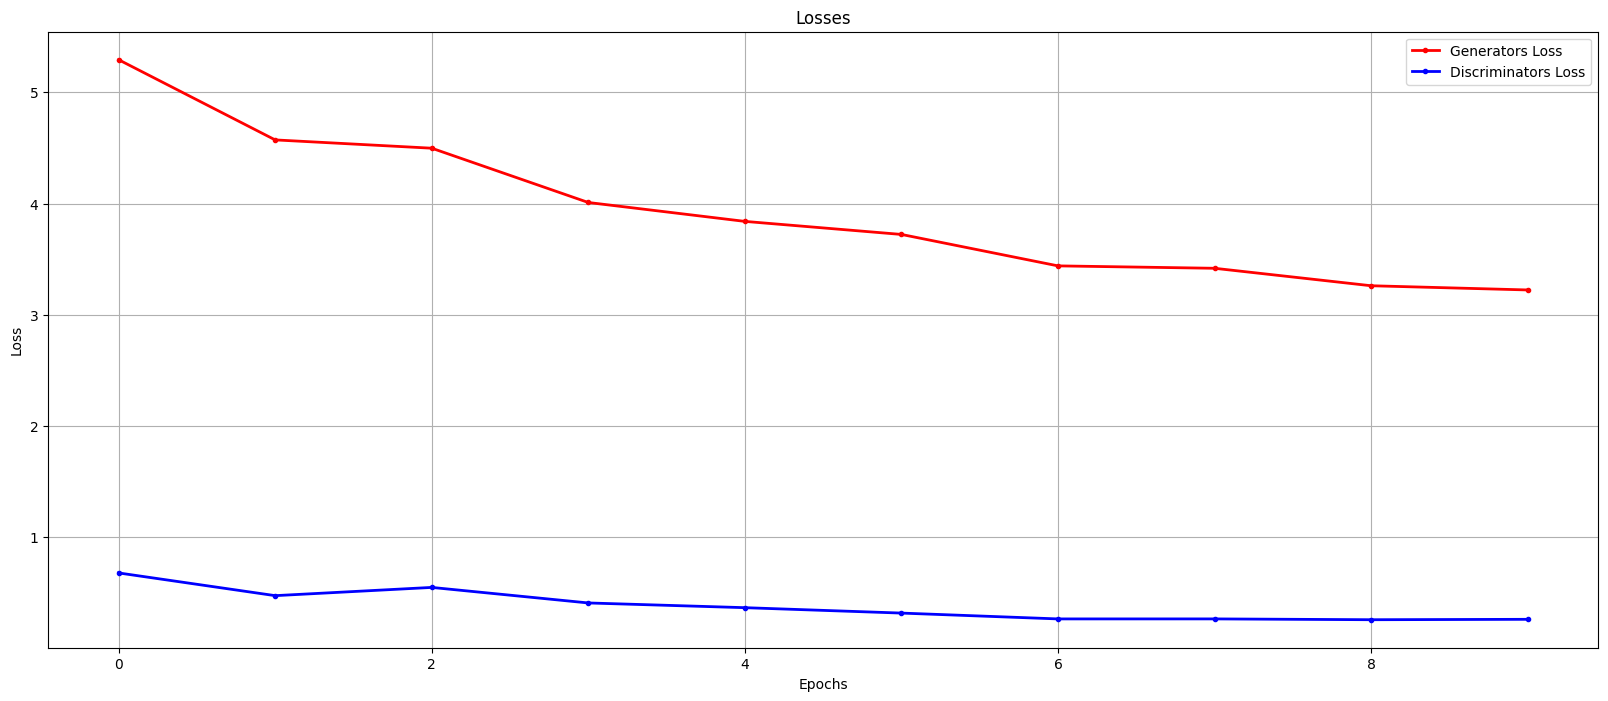

In [12]:
# Plotting the Generator and Discriminator Loss Curves
history.show()

## Submission: Generating Monet-Style Images for Evaluation

In this final stage, we use the trained `generator_photo2monet` model to transform real photographs into Monet-style images for submission or evaluation.

### Key Steps:
- Load and preprocess photo images from the dataset.
- Translate batches of images using the **Photo → Monet generator**.
- Save the generated images as `.jpg` files in the `../images` directory.
- Finally, compress the entire image directory into a `.zip` file for easy download or competition submission.

### Notes:
- The generator is intentionally kept in **training mode** to retain stochasticity (e.g., dropout noise), which may enhance diversity in outputs.
- The `unnorm()` function ensures that output images are properly denormalized before saving.

In [13]:
# Generating and Saving Translated Monet-Style Images for Submission

# Path to real photo images (inference input)
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
print(f"Total photos to translate: {len(files)}")

# Directory to save generated images
save_dir = '../images'
os.makedirs(save_dir, exist_ok=True)

# Apply same normalization used in training (no resize needed)
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Switch generator to train mode to enable dropout-based diversity
generator_photo2monet.train()

# Generate and save Monet-style outputs in batches
for i in range(0, len(files), batch_size):
    images = []
    for j in range(i, min(len(files), i + batch_size)):
        image = Image.open(files[j])
        image = generate_transforms(image)
        images.append(image)
    real_photo = torch.stack(images, 0)

    # Translate photos → Monet-style
    fake_images = generator_photo2monet(real_photo.to(device)).detach().cpu()

    # Save each generated image
    for j in range(fake_images.size(0)):
        img = unnorm(fake_images[j])  # Unnormalize for display
        img = transforms.ToPILImage()(img).convert("RGB")
        img.save(os.path.join(save_dir, f"{i + j + 1}.jpg"))

# Create ZIP file for submission
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Total photos to translate: 7038


'/kaggle/working/images.zip'

## Discussion and Conclusions

Throughout the training process, we observed a consistent **decrease in both generator and discriminator losses**, which is a strong indicator of effective adversarial training and model convergence.

### Performance Trends:
- **Generator Loss**: Decreased from **5.2935** in the first epoch to **3.2240** in the tenth epoch, reflecting improved ability to generate realistic Monet-style images.
- **Discriminator Loss**: Dropped from **0.6803** to **0.2634**, suggesting increased effectiveness in distinguishing real from generated images.

### Interpretation:
- The reduction in **generator loss** suggests that the model learned to better translate photos into Monet-like artworks.
- The declining **discriminator loss** confirms that the discriminators became more skilled at validating image authenticity—helping the generators improve further through adversarial feedback.

### Final Thoughts:
These outcomes indicate that the **CycleGAN model successfully learned cross-domain mappings** between real photos and Monet-style paintings. The convergence of loss functions shows that the adversarial and cycle-consistency objectives were effectively optimized.

This experiment demonstrates how CycleGANs can harness adversarial learning to achieve visually compelling, domain-adaptive image synthesis—bridging the gap between data science and artistic expression.
